This notebook reproduces the plots in section 3.(LCLS Benchmark) from the paper ["Benchmarking Collective Effects of Electron Interactions in a Wiggler with OPAL-FEL"](https://arxiv.org/pdf/2112.02316.pdf). More specifically it benchmarks OPAL-FEL with the data from a [paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.214801) by MacArthur et al.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

# Make plot backgrounds white, rather than transparent
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

fs = 16  # Fontsize

def printf(string, number, dec = 2, sci = True):
    'print float as a string in a nice format'
    if sci:
        print(string +  "{:.{dec}e}".format(number, dec = dec))
    else:
        print(string +  "{:.{dec}f}".format(number, dec = dec))


# Initial bunch conditions from the paper

## Get initial bunch parameters from paper

These are the initial bunch parameters that we know from the paper by MacArthur et al.




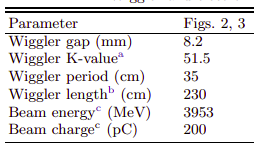

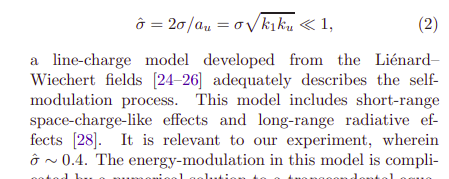

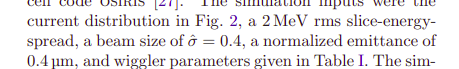

In [2]:
from IPython.display import Image, display
print("These are the initial bunch parameters that we know from the paper by MacArthur et al.\n\n")

display(Image("plots_from_MacArthur_paper/bunch_parameters.png"),
        Image("plots_from_MacArthur_paper/sigma.png"),
        Image("plots_from_MacArthur_paper/emittance.png"))



In [16]:
# Bunch initial parameters as described in the paper

numPart = int(5e5)  # Number of macro-particles used in the OPAL-FEL simulation
fn = 'simulation/initialDistro.in'  # File to save the distribution
Q = 200e-12  # Charge in C

avgE = 3953  # Energy in MeV
sigE = 2  # 2 MeV energy spread for whole beam. 
c = 3e8  # Light speed in m/s
gamma = avgE / .511
beta = np.sqrt(1 - 1 / np.power(gamma,2))
print('beta = ', beta)
printf('gamma = ', gamma)

K = 51.5  # Wiggler strength parameter
lu = 35e-2  # wiggler period λ_u in m
gamma_ = gamma / np.sqrt( 1 + .5 * np.power(K,2.) )  # Reduced gamma in undulator
beta_ = np.sqrt( 1 - 1 / np.power(gamma_,2) )
print('beta_ = ', beta_)
printf('gamma_ = ', gamma_)
lr = lu / 2 / np.power(gamma_,2)  # Resonant radiation wavelength λ_r in m
printf('lu = ', lu)
printf('lr = ', lr)
kr = 2*np.pi / lr
ku = 2*np.pi / lu

sigHat = .4  # Normalised transverse spread as in the paper
sigr = sigHat / np.sqrt( kr * ku )  # Tansverse rms in m
lz = 60e-15 * 3e8  # Approximate length of the bunch in m. Used to compute particles-per-cell NpC in simulation
printf('transverse spread = ', sigr)
printf('bunch length = ', lz)
dx = 10e-6  # Mesh-spacing in m, as used in the simulation. Transverse mesh size should be small enough to resolve the bunch
dy = dx
dz = .07e-6  # dz needs to be small enough to resolve the resonant wavelength λ_r
NpC = numPart / (lz * sigr**2 * np.pi) * (dx * dy * dz)
print('NpC at beginning = ', NpC)  # Number of particles per cell at the start of the simulation. If NpC is too small we might have spurious noise in the simulation. Through experimentation it was found that NpC>10 is in general enough. So numPart and dx,dy,dz should be chosen to get a good NpC.

emitxN = .4e-6 # Transverse normalised emittance in m
# If we assume corr(x,px) = 0 at the start of the simulation, then emitx_normalised = sig_x * sig_px
sigpr = emitxN / sigr
print('average momentum = ', beta*gamma, '\ntransverse momentum spread = ', sigpr)


# Time that simulation should last
# This is not necessary since OPAL-FEL automatically computes how ong the FDTD simulation should last, and when to switch back to the Poisson solver. However, you can force the FDTD simulation to last a given time with the parameter TOTALTIME in OPAL-FEL. In that case, this is the calculation of how long TOTALTIME should be
Lu = 6 * lu  # Wiggler length
lTrun = 9e-6  # Half bunch length approximately
lmin = lTrun * beta / beta_ - 5 * lu * ( 1 + beta / beta_ )
lcent = lmin - lTrun / ( 1 - beta_ * beta )
print( 'lmin in lab frame = ', lmin, ', lcent in lab frame is = ', lcent)
timeDiff = beta_ / c / ( 1 - beta_ * beta ) * lTrun
print('time difference in lab frame between center and maxZ particle is ', timeDiff)
totTime =  2 * -lcent / beta / c + Lu / beta_ / c
print( 'simulation time = ', totTime )  # This is the time that you should give to TOTALTIME, if you want to override what OPAL-FEL automatically does


beta =  0.9999999916447745
gamma = 7.74e+03
beta_ =  0.999988911509873
gamma_ = 2.12e+02
lu = 3.50e-01
lr = 3.88e-06
transverse spread = 7.42e-05
bunch length = 1.80e-05
NpC at beginning =  11.242925312534826
average momentum =  7735.812068437952 
transverse momentum spread =  0.005391092963984953
lmin in lab frame =  -3.500010390351366 , lcent in lab frame is =  -4.311051707879512
time difference in lab frame between center and maxZ particle is  2.7034410810150153e-09
simulation time =  3.5740422579620394e-08


In [112]:
# This cell is obsolete and no longer necessary

# # Make the shape

# x = np.linspace( 0, 60, 500)
# func = []

# # Flat part
# y = np.zeros( x.size )
# for i, yi in enumerate(y):
# #     if x[i] < 15:
# #         y[i] = linear( x[i], 5, 12, 0, 5 )
#     if x[i] > 15 and x[i] < 52:
#         y[i] = linear( x[i], 17, 50, 4, 2 )
# func.append(y)
        
# # Gaussian left
# y = gaussian( x, 16, 2, height = 16)
# func.append(y)
# y = gaussian( x, 16, 4, height = 7.5 )
# func.append(y)

# # Gaussian right
# y = quadratic( x, 52, .8, height = 7.5)
# func.append(y)
# y = gaussian( x, 52, 2.5, height = 7.5 )
# func.append(y)

# # Plot
# fig = plt.figure()
# ytot = np.zeros(x.size)
# for y in func:
#     plt.plot( x, y )
#     for i, yi in enumerate(y):
#         if yi > ytot[i]:
#             ytot[i] = yi
# plt.plot( x, ytot, linewidth = 4, linestyle = ':' )   
# fig.set_size_inches(15, 4)
# plt.xlim( left = 0 )
# plt.ylim( bottom = 0, top = 17)
# plt.grid()

## Generate longitudinal particle distribution

Bunch longitudinal distribution from the MacArthur paper.


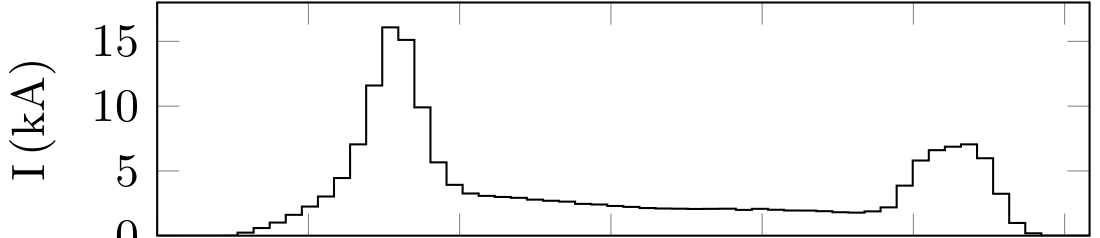

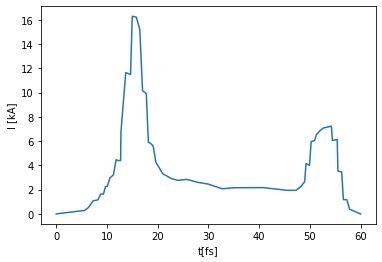

In [20]:
print("Bunch longitudinal distribution from the MacArthur paper.")
display(Image("plots_from_MacArthur_paper/current_macArthur.png"))
shape = pd.read_csv('plots_from_MacArthur_paper/inputCurrent.csv', names = ['t', 'I'])
shape = shape.sort_values( by = ['t']  )
x = np.array(shape['t'])
ytot = np.array(shape['I'])
plt.plot( x, ytot )
plt.xlabel('t[fs]')
plt.ylabel('I [kA]')
plt.show()

In [23]:
# Make the z distribution with the rejection method

np.random.seed(42)
q = Q / numPart  # Charge per particle

f = interpolate.interp1d(x, ytot)
z = np.zeros(numPart)
for i in range(numPart):
    reject = True
    while reject:
        xr = np.random.uniform( 0.0, 60 )
        yr = np.random.uniform( 0.0, 20 )
        if yr <= f(xr):
            z[i] = xr
            reject = False
       
z *= 1e-15  # Unit conversion to s

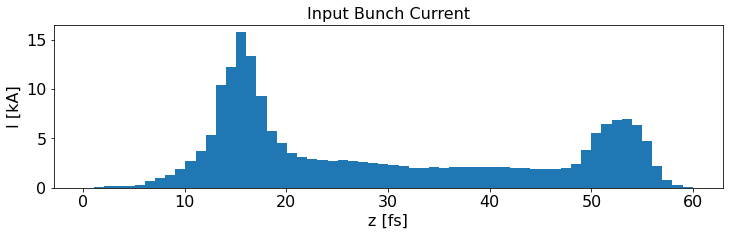

In [22]:
# Plot bunch current

fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
nbins = 60
binsize = (np.max(z) - np.min(z)) / nbins
ax.hist( z*1e15, bins = nbins, weights = q * 1e-3 / binsize * np.ones(z.size) )
ax.set_xlabel('z [fs]', fontsize = fs)
ax.set_ylabel('I [kA]', fontsize = fs)
ax.set_yticks([0, 5, 10, 15])
ax.tick_params( axis = 'both', labelsize = fs )
fig.set_size_inches(12,3 )
ax.set_title('Input Bunch Current', fontsize = fs)
plt.show()



## Make the distribution in the other 5 dimensions of phase-space


In [24]:
# Longitudinal beam size
zm = np.array( z * beta * c )  # time to position conversion
zm -= np.average(zm)

np.random.seed(42)

# Transerse beam size Gaussian distribution
x = np.random.normal( 0, sigr, len(zm))
y = np.random.normal( 0, sigr, len(zm))

# Energy
E = np.random.normal( avgE, sigE, len(zm))  # in MeV

# Transverse momenta
px = np.random.normal( 0, sigpr, len(zm))
py = np.random.normal( 0, sigpr, len(zm))

# Longitudinal momentum
pz = np.zeros(len(zm))
for i in range(len(zm)):
    g = E[i] / .511
    gb2 = g**2 * ( 1 - 1 / g**2 )
    pz[i] = np.sqrt( gb2 - px[i]**2 - py[i]**2 )

print('mean p = ', np.average(px), ', ', np.average(py), ', ', np.average(pz))

mean p =  8.958687634778182e-06 ,  5.552258757312271e-06 ,  7735.813106669655


## Write distribution to file, in the format that OPAL-FEL can read

In [25]:
file = open( fn, mode = 'w' )
file.write( str( str(numPart) + '\n' ) )
file.close()

df = pd.DataFrame([x,px,y,py,zm,pz])
df = df.T
df.to_csv( fn, sep = '\t', header = False, index = False, mode = 'a' )

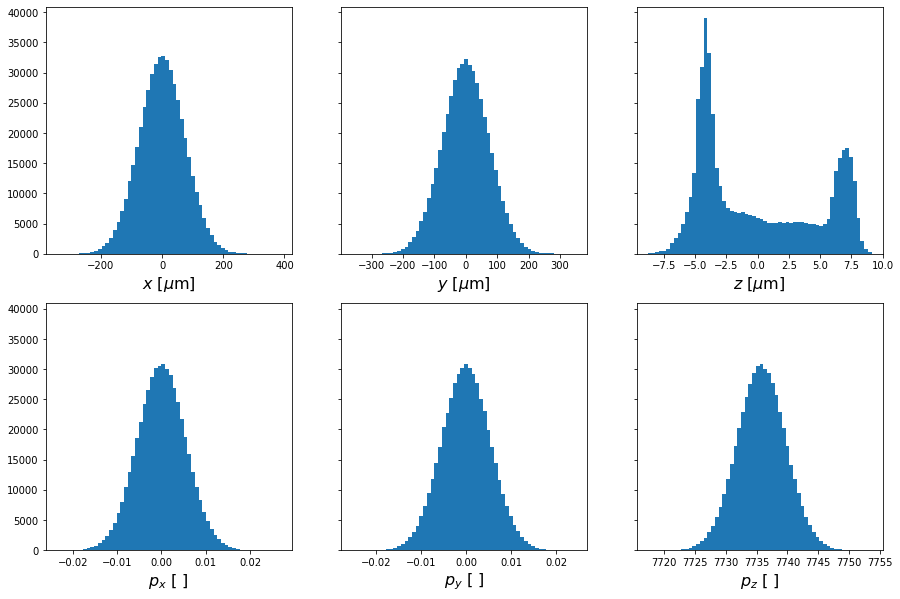

In [26]:
# Plot bunch distirbution in 6 dimensions of phase space

fig, ax = plt.subplots( 2, 3, sharey = True)
fig.set_size_inches(15, 10)
ax[0,0].hist( x*1e6, bins = nbins )
ax[0,0].set_xlabel('$x$ [$\mu$m]', fontsize = fs)
ax[0,1].hist( y*1e6, bins = nbins )
ax[0,1].set_xlabel('$y$ [$\mu$m]', fontsize = fs)
ax[0,2].hist( zm*1e6, bins = nbins )
ax[0,2].set_xlabel('$z$ [$\mu$m]', fontsize = fs)
ax[1,0].hist( px, bins = nbins )
ax[1,0].set_xlabel('$p_x$ [ ]', fontsize = fs)
ax[1,1].hist( py, bins = nbins )
ax[1,1].set_xlabel('$p_y$ [ ]', fontsize = fs)
ax[1,2].hist( pz, bins = nbins )
ax[1,2].set_xlabel('$p_z$ [ ]', fontsize = fs)
plt.show()


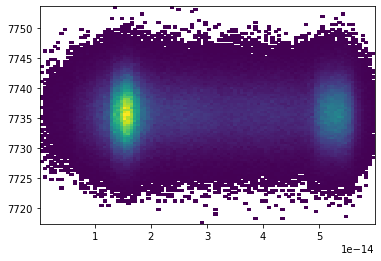

In [27]:
plt.hist2d(z, pz, bins = 100, cmin = 1)
plt.show()
